# Analysis of Vodafone users' fluxes

The study of the flux of people inside urban areas is of paramount importance to achieve an optimal understanding of emerging critical issues in the local mobility, and to explore areas of potential improvements in the infrastructures and local transports.

The mobility of users within and toward Padova has been monitored using the data provided by the Vodafone mobile carrier, which provides the information based on the users' connections to the network cells.
The data provided by the carrier encompasses the monitoring of the users connected to the Vodafone network in Padova in a four-month period from February to May of 2018.

To provide statistical insights on the number and the flow of users, the data is aggregated based on the origin and movements of the users by averaging the number of connections during the time of the monitoring.

To further avoid privacy violation issues, all observations with less than 30 units (e.g. day-areas for which $<$ 30 users have contributed) have been discarded and/or merged into dedicated categories (indicated with "altro", or "other").


## Datasets 

The data is provided in `.csv` files.

* __day_od.csv__: table of the origins and destinations of the users averaged by the day of the week. The data is provided with details of the month, type of user (resident in Padova/Italian visitor/foreign visitor), country of provenance, together with the province and comune of the user (if available).
* __distinct_users_day.csv__: table of the number of distinct users by origin. The data is provided with details of the month, type of user (resident in Padova/Italian visitor/foreign visitor), country of provenance, together with the province and comune of the user (if available).

The information is stored in the fields according to the following scheme: 

- __MONTH__: month analyzed
- __DOW__: day analyzed
- __ORIGIN__: users' origin area (do not consider this field)
- __DESTINATION__: users' destination area (do not consider this field)
- __CUST_CLASS__: user type (resident / Italian visitor / foreigner visitor)
- __COD_COUNTRY__: users' country code (e.g. 222=Italy)
- __COD_PRO__: users' province code (e.g. 12=Varese) 
- __PRO_COM__: users' comune code (e.g. 12026=Busto Arsizio)
- __FLOW__: number of movements for given date-time (with a minimum of 30 users)
- __VISITORS__: overall number of users 

Together with the data files, three lookup-tables are provided to allow matching the Italian institute of STATistics (ISTAT) country, province and comune codes to the actual names.

* __codici_istat_comune.csv__: lookup file containing the mapping between _comune_ ISTAT code-names
* __codici_istat_provincia.csv__: lookup file containing the mapping between _province_ ISTAT code-names
* __codici_nazioni.csv__: lookup file containing mapping the _country_ code to its name

Additional information, useful for the study of the flow of users, as the number of inhabitants of each province and the distance between Padova and all other Italian provinces can be extracted based on the data collected by the ISTAT:

   - English: https://www.istat.it/en/analysis-and-products/databases, Italian: https://www.istat.it/it/dati-analisi-e-prodotti/banche-dati
   
   - English/Italian: https://www.istat.it/en/archive/157423, Italian: https://www.istat.it/it/archivio/157423
   
   - `.zip` package containing the distances between comuni in Veneto region: http://www.istat.it/storage/cartografia/matrici_distanze/Veneto.zip

If deemed useful, the open repository [https://github.com/openpolis/geojson-italy](https://github.com/openpolis/geojson-italy) contains a `.json` file with the geographical coordinates of the provences and comuni of Italy.


## Assignments

1. Data preparation: the csv files are originated from different sources, hence resulting in differences in the encoding and end-of-lines that have to be taken into account in the data preparation phase. Make sure each .csv file is properly interpreted.

   1.1 Ranking of visitors from foreign countries: based on the number of total visitors per each country, create a ranked plot of the first 20 countries with the most visitors
   
   1.2 Ranking of Italian visitors by province, weighted by the number of inhabitants: based on the number of total visitors per Italian province, create a ranked plot of the first 20 provinces with the most visitors taking into account the number of inhabitants.


2. Study of the visitors' fluxes: you are asked to provide indications on how to invest resources to improve the mobility towards Padova. Consider the three main directions of visitors and commuters getting to Padova through the main highways (from south, A13 towards Bologna-Roma; from west, A4 towards Milano-Torino; from north-east, A4 towards Venice-Trieste). Evaluate which of the three directions has to be prioritized.

   2.1 Consider a simplified case involving only the mid-range mobility, based on the number of visitors/commuters from the nearby regions only
   
   2.2 Consider the provinces located on the three directions that are mostly contributing to the flow of weekend visitors and working daily commuters by performing a more detailed study of the fluxes based on the day of the week. Use the data available to provide what you believe is the best possible answer.


3. Plot the distribution of the number of visitors by the distance of the province of origin. Determine which kind of function should be used to describe the distribution.

   3.1 Assuming an analytic form can be used to describe the trend, create a regression or a fit to estimate the expected number of visitors by the distance of the province of origin and the corresponding uncertainties. Illustrate the difference between the resulting regression with respect to the numbers provided by the Vodafone monitoring, and highlight the five most striking discrepancies from the expectations.

# Imports

In [ ]:
import chardet #Used to detect the encoding of the CSV files
import codecs  #Used to read the CSV UTF-16
import io      #Used to write the CSV ISO-8859-1
import pandas as pd #Used to store data into dataframes
import matplotlib.pyplot as plt #Used to represent data
import numpy as np #Used to rename the column of dataframes

# 1 Data preparation

In [ ]:
#list of csv files
filename_codici_istat_comuni = "data\codici_istat_comune.csv"
filename_codici_istat_provincia = "data\codici_istat_provincia.csv"
filename_codici_nazioni = "data\codici_nazioni.csv"
filename_day_od = "data\day_od.csv"
filename_distinct_user_day = "data\distinct_users_day.csv"
filename_distance_to_pd = "data\R05_PD.csv"
filename_distance_to_pd_txt = "data\R05_PD.txt"

#Creating a list to boost performances of the loops
filenames = [filename_codici_istat_comuni, filename_codici_istat_provincia, filename_codici_nazioni,
             filename_day_od, filename_distinct_user_day, filename_distance_to_pd]

In [ ]:
# #Function which returns the encoding of each csv file
def check_encoding(file):
    #Read the file
    with open(file, 'rb') as f:
        #Detect the encoding
        result = chardet.detect(f.read())

    #Return a list of the encodings
    return result['encoding']

In [ ]:
# #Function wich converts the UTF-16 encoded files into ISO-8859-1 encoded files
def encoding_converter(files):
    for file in files:
        #Saving the encoding of each file
        encodings = check_encoding(file)

        # If the encoding is different to ISO-8859-1 it has to be converted
        if encodings == 'ascii' :
            # Open the file and saving the content
            with codecs.open(file, 'r', 'ascii') as f:
                data = f.read()

            # Overwrite the file with a new encoding
            with io.open(file, 'w', encoding='utf-8') as f:
                f.write(data)

        if encodings == 'utf-16':
            # Open the file and saving the content
            with codecs.open(file, 'r', 'utf-16') as f:
                data = f.read()

            # Overwrite the file with a new encoding
            with io.open(file, 'w', encoding='latin1') as f:
                f.write(data)

### 1.1 Ranking of visitors from foreign countries

### 1.2 Ranking of visitors from Italy

# 2 Study of the visitors' fluxes

Praticamente bisogna controllare tutti i caselli autostradali delle 3 autostrade
Sommare tutti i flows attraverso i comuni delle 3 autostrade
Potrei plottare in base al casello, per ogni autostrada
I codici delle persone intendono l'origine delle persone
In realtà è una semplificazione perchè immagino che tutti quelli del nordest abbiano preso l'autostrada A4. Farò così:
Suddivido in 4 zone: 
1. NordEst (A4 To-Mi) ad Est di Padova
2. NordOvest (A4 Ts-Ve)
3. La parte sinistra dell'Italia prende l'A1 che poi diventa A13
4. La parte destra dell'Italia prende direttamente l'A13 (Emilia Marche Abruzzo Molise Puglia)

In [ ]:
def toll_booths(highway = ""):   
    data_tolls = None
    if highway == "A4To-Mi" :
        data_tolls = pd.DataFrame({'COMUNE':["Torino", "Borgo d'Ale", "Santhià", "Carisio", "Balocco", "Greggio", "Biandrate", "Novara",
            "Mesero", "Arluno", "Rho", "Milano", "Monza", "Agrate", "Cavenago", "Trezzo", "Capriate", "Dalmine",
            "Bergamo", "Seriate", "Grumello", "Ponte Oglio", "Palazzolo", "Rovato", "Ospitaletto", "Castegnato",
            "Brescia", "Desenzano", "Sirmione", "Peschiera", "Sommacampagna", "Verona", "Soave", "Montebello",
            "Montecchio", "Vicenza", "Grisignano"]})
        
    elif highway == "A4Ts-Ve":
        data_tolls = pd.DataFrame({"COMUNE": ["Trieste", "Redipuglia", "Palmanova", "San Giorgio di Nogaro", 
                                              "Latisana", "San Stino di Livenza", "Cessalto", "San Donà di Piave", 
                                              "Meolo", "Preganziol", "Martellago", "Spinea"]})

    elif highway == "A1Ro-Bo":
        data_tolls = pd.DataFrame({'COMUNE':["Sasso Marconi", "Rioveggio", "Pian del Voglio", "Roncobilaccio", "Barberino di Mugello",
            "Calenzano", "Firenze", "Incisa", "Valdarno", "Arezzo", "Monte San Savino", "Valdichiana", "Chiusi",
            "Fabro", "Orvieto", "Attigliano", "Orte", "Magliano Sabina", "Ponzano Romano", "Guidonia Montecelio",
            "Valmontone", "Colleferro", "Anagni"]})

    else: # highway == "A13Bo-Pd"
        #Altedo è fraz di Bologna
        data_tolls = pd.DataFrame({'COMUNE':["Bologna", "Ferrara", "Occhiobello", "Rovigo", "Boara Pisani", "Monselice"]})
        
    return data_tolls

In [ ]:
def possible_highway(data):
    # Ignore Padova because they do not take the highway
    data_no = data.loc[(data['REGION'] == "Lombardia") | (data['REGION'] == "Trentino-Alto Adige") | (data['REGION'] == "Valle d'Aosta")
                       | (data['REGION'] == "Piemonte") | (data['REGION'] == "Liguria")
                       | (data['COD_PRO'] == 24) | (data['COD_PRO'] == 23)]  # Vicenza and Verona
    
    data_ne = data.loc[(data['REGION'] == "Friuli-Venezia Giulia") |
                        (data['COD_PRO'] == 25) | (data['COD_PRO'] == 26) | (data['COD_PRO'] == 27)]  # Belluno, Treviso, and Venezia
    
    data_so = data.loc[(data['REGION'] == "Emilia Romagna") | (data['REGION'] == "Marche") | (data['REGION'] == "Abruzzo")
                       | (data['REGION'] == "Molise") | (data['REGION'] == "Puglia") 
                       | (data['COD_PRO'] == 29)]  # Rovigo
    
    data_se = data.loc[(data['REGION'] == "Toscana") | (data['REGION'] == "Umbria") | (data['REGION'] == "Lazio")
                       | (data['REGION'] == "Campania") | (data['REGION'] == "Basilicata") | (data['REGION'] == "Calabria")]
                       
    data_groups  = [data_no, data_ne, data_so, data_se]
    list_highways = ["A4To-Mi", "A4Ts-Ve", "A13Bo-Pd", "A1Ro-Bo"]

    for x in range(0, len(data_groups)):
        # CALCULATION OF FLOWS OF MUNICIPALITIES WITH TOLLBOOTH
        comuni_toll = toll_booths(list_highways[x])

        # Add a new column "toll booth number" to the DataFrame
        comuni_toll['N_TOLL'] = range(1, len(comuni_toll) + 1)

        # Check for matches, if found, calculate the sum
        data_comuni_toll = pd.merge(data_groups[x], comuni_toll, on="COMUNE")

        # CALCULATION OF FLOWS OF PROVINCES WITH TOLLBOOTH
        # Otherwise, check the province
        comuni_codes = pd.read_csv(filename_codici_istat_comuni, encoding='latin1', usecols=['COMUNE', 'PRO_COM', 'COD_PRO', 'COMUNE_CAPOLUOGO'])
        comuni_toll = pd.merge(comuni_toll, comuni_codes, on="COMUNE")
        # Subtraction between two dataframes
        data_without_comuni_toll = data_groups[x].merge(data_comuni_toll, how='outer', indicator=True).query('_merge == "left_only"').drop('_merge', axis=1)
        # Take the provinces of the municipalities with toll booths
        data_province_toll = data_without_comuni_toll.drop(['COMUNE','PRO_COM'], axis= 1)
        data_province_toll = pd.merge(data_province_toll, comuni_toll, on='COD_PRO')
        data_province_toll = data_province_toll.groupby(['COD_PRO'])[['VISITORS']].sum()

        # Merge the two DataFrames based on the 'COD_PRO' column
        data_com_pro_toll = pd.merge(data_province_toll, data_comuni_toll, suffixes=('_df1', '_df2'), on='COD_PRO', how='outer')

        # Sum the values of the 'visitors' column of the two DataFrames
        data_com_pro_toll['VISITORS'] = data_com_pro_toll['VISITORS_df1'].fillna(0) + data_com_pro_toll['VISITORS_df2'].fillna(0)
        data_com_pro_toll = data_com_pro_toll.drop(['VISITORS_df1','VISITORS_df2'], axis= 1)

        data_com_pro_toll = data_com_pro_toll.dropna()

        # CALCULATION OF FLOWS FOR USERS WHO DO NOT HAVE A TOLLBOOTH IN THE PROVINCE -> UNIFORMLY DISTRIBUTE AMONG THE TOLL BOOTHS
        # Take all the provinces of data_groups[x] -> Remove those with the toll booth
        province = set(data_groups[x]['COD_PRO'].unique())
        province_with_toll = set(data_com_pro_toll['COD_PRO'].unique())
        province_without_toll = pd.DataFrame({'COD_PRO': list(province - province_with_toll)})
        
        data_region_toll = pd.merge(data_groups[x], province_without_toll, on="COD_PRO")
        
        # Sum the flow of the provinces
        data_region_toll = data_region_toll.groupby('COD_PRO')[['VISITORS']].sum()
        # Uniformize
        if len(data_com_pro_toll) == 0:
            data_groups.pop(x)
        else:
            flow = (data_region_toll['VISITORS'].sum() / len(data_com_pro_toll)).round()
            # Sum
            data_com_pro_toll['VISITORS'] = data_com_pro_toll['VISITORS'] + flow
            
            data_groups[x] = data_com_pro_toll
    
    return data_groups


In [ ]:
def add_region(data):
    # Dictionary mapping region names to their respective codes
    regioni = {
        'Abruzzo': 13,
        'Basilicata': 17,
        'Calabria': 18,
        'Campania': 15,
        'Emilia Romagna': 8,
        'Friuli-Venezia Giulia': 6,
        'Lazio': 12,
        'Liguria': 7,
        'Lombardia': 3,
        'Marche': 11,
        'Molise': 14,
        'Piemonte': 1,
        'Puglia': 16,
        'Sardegna': 20,
        'Sicilia': 19,
        'Toscana': 9,
        'Trentino-Alto Adige': 4,
        'Umbria': 10,
        'Valle d\'Aosta': 2,
        'Veneto': 5
    }
    
    # Initialize a list to store the names of the regions
    region_names = []
    
    # Iterate through each row of the DataFrame
    for index, row in data.iterrows():
        # Get the region code from the 'COD_REG' column
        cod_reg = row['COD_REG']
        
        # Search for the region name corresponding to the code in the 'COD_REG' column
        for region_name, region_code in regioni.items():
            if cod_reg == region_code:
                # Add the region name to the list
                region_names.append(region_name)
                break
        else:
            # If the region code is not present in the 'regioni' dictionary, add None
            region_names.append(None)
    
    # Add the list of region names as a new 'REGION' column in the DataFrame
    data['REGION'] = region_names

    return data


In [ ]:
def plotter(data, highway=True):
    # Extract the relevant data from the DataFrame
    # Since the Italian state declared the independence of the province of Monza only in 2004, its code is messy,
    # so we manually reorder it after sorting by 'N_TOLL'
    if highway:
        data = data.sort_values(by='N_TOLL')
        comuni = data['COMUNE']
    else:
        comuni = data['PROVINCIA']
    visitatori = data['VISITORS']
    visitatori_cumulative = data['VISITORS'].cumsum()

    # Create the bar plot
    plt.figure(figsize=(10, 6))
    plt.bar(comuni, visitatori, color='skyblue', alpha=0.5)
    plt.plot(comuni, visitatori_cumulative, color='red')  # Plot cumulative visitors

    # Add titles and labels
    plt.title('Number of visitors per municipality')
    plt.xlabel('Municipality')
    plt.ylabel('Number of visitors')
    plt.xticks(rotation=45, ha='right')
    # Set the scale to avoid the exponential notation for large numbers on the y-axis
    plt.ticklabel_format(style='plain', axis='y')

    # Display the plot
    plt.tight_layout()
    plt.show()


In [ ]:
def visitors_fluxes(file_customers, dow_study=False, mid_range=False, highway=True):
    # Consider the ISTAT province codes
    comuni_codes = pd.read_csv(filename_codici_istat_comuni, encoding='latin1', usecols=['COMUNE', 'PRO_COM', 'COD_PRO'])
    provinces_codes = pd.read_csv(filename_codici_istat_provincia, encoding='latin1', usecols=['COD_PRO', 'COD_REG'])

    codes = pd.merge(comuni_codes, provinces_codes, on='COD_PRO')

    if not dow_study:
        # Now take the data of the customers and see what's their origin and their destination
        customers_data = pd.read_csv(file_customers, encoding='latin1', usecols=['VISITORS', 'PRO_COM'])
    else:
        customers_data = pd.read_csv(file_customers, encoding='latin1', usecols=['VISITORS', 'DOW', 'PRO_COM'])

    customers_data.dropna(axis=0, inplace=True)

    # Add region information based on the province codes
    users = add_region(codes)

    if mid_range:
        # Filtering regions based on specified criteria
        maskLombardia = (users['REGION'] == 'Lombardia')
        maskTrentino = (users['REGION'] == 'Trentino-Alto Adige')
        maskFriuli = (users['REGION'] == 'Friuli-Venezia Giulia')
        maskEmilia = (users['REGION'] == 'Emilia Romagna')
    
    if highway:
        if mid_range:
            # Filter users based on specified mid-range regions
            users = users.loc[maskLombardia | maskTrentino | maskFriuli | maskEmilia]
    
        # Join between customers_data and province_codes to filter the province_codes we're interested in
        customers_data = customers_data.groupby(['PRO_COM'])[['VISITORS']].sum().reset_index()
        data = pd.merge(customers_data, users, on='PRO_COM')

        # Obtain possible highways and their traffic data
        highways = possible_highway(data)

        # Plot the traffic flow for each highway region
        for i, region_group in enumerate(highways):
            highways[i] = region_group.drop(['COD_PRO', 'PRO_COM', 'COD_REG', 'REGION'], axis=1)
            if not dow_study:
                plotter(region_group)
            else:
                dow_plotter(region_group)
    else:
        # If not highway mode, handle urban roads
        customers_data = pd.read_csv(file_customers, encoding='latin1', usecols=['VISITORS', 'PRO_COM', 'COD_PRO'])
        # Divide provinces into 4 groups: North, East, South, West, based on the region's position
        users_ovest = users.loc[maskLombardia]
        users_nord = users.loc[maskTrentino]
        users_est = users.loc[maskFriuli]
        users_sud = users.loc[maskEmilia]

        group_list = [users_ovest, users_nord, users_est, users_sud]

        customers_data = customers_data.drop(['PRO_COM'], axis=1)
        # Join between customers_data and province_codes to filter the province_codes we're interested in
        customers_data = customers_data.groupby('COD_PRO').sum()

        provinces = pd.read_csv(filename_codici_istat_provincia, encoding='latin1', usecols=['COD_PRO', 'PROVINCIA'])
        customers_data = pd.merge(customers_data, provinces, on='COD_PRO')

        for users_group in group_list:
            data = pd.merge(customers_data, users_group, on='COD_PRO')
            data = data.groupby('PROVINCIA')[['VISITORS']].sum().reset_index()

            plotter(data)

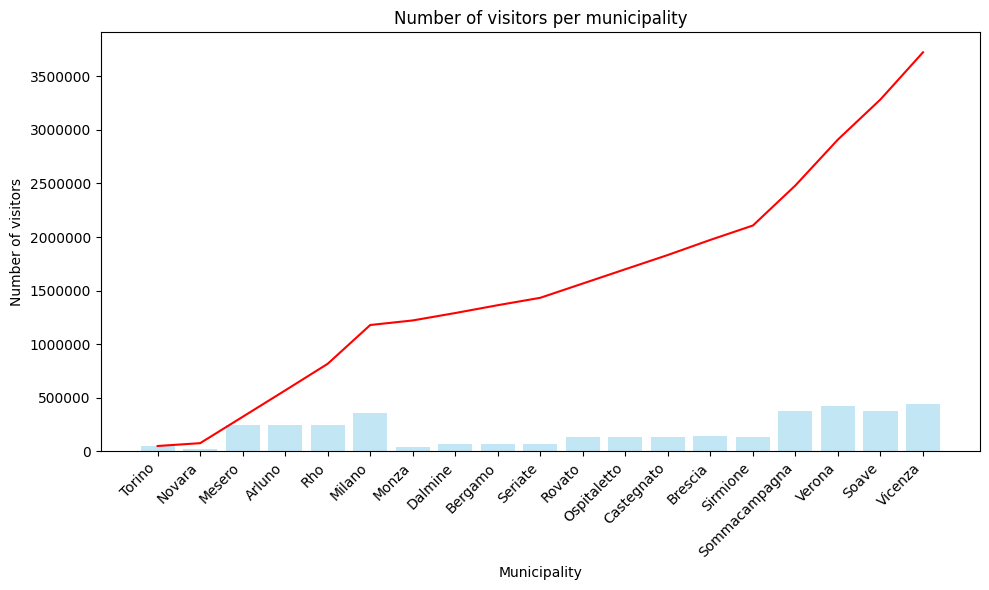

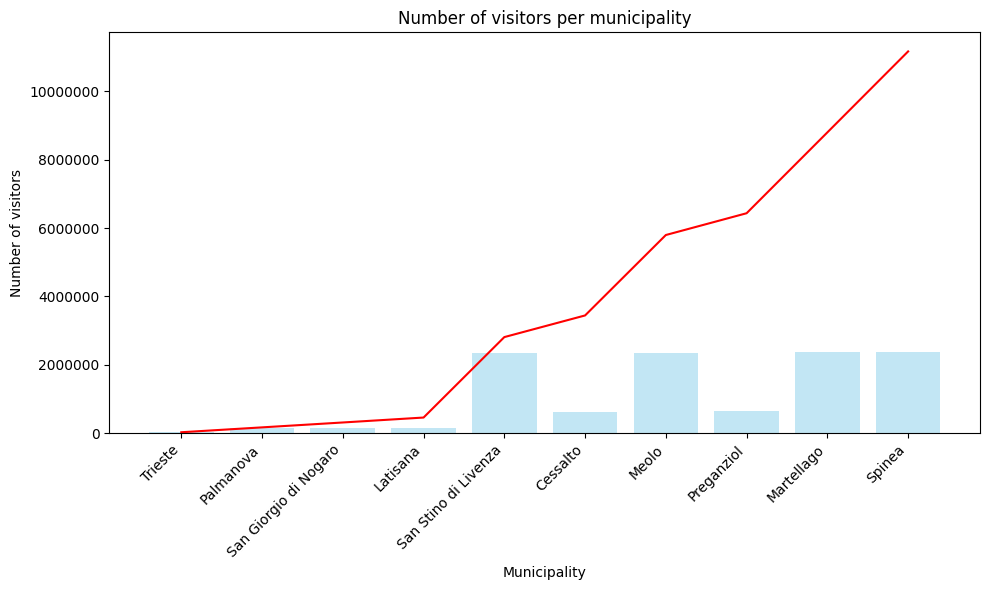

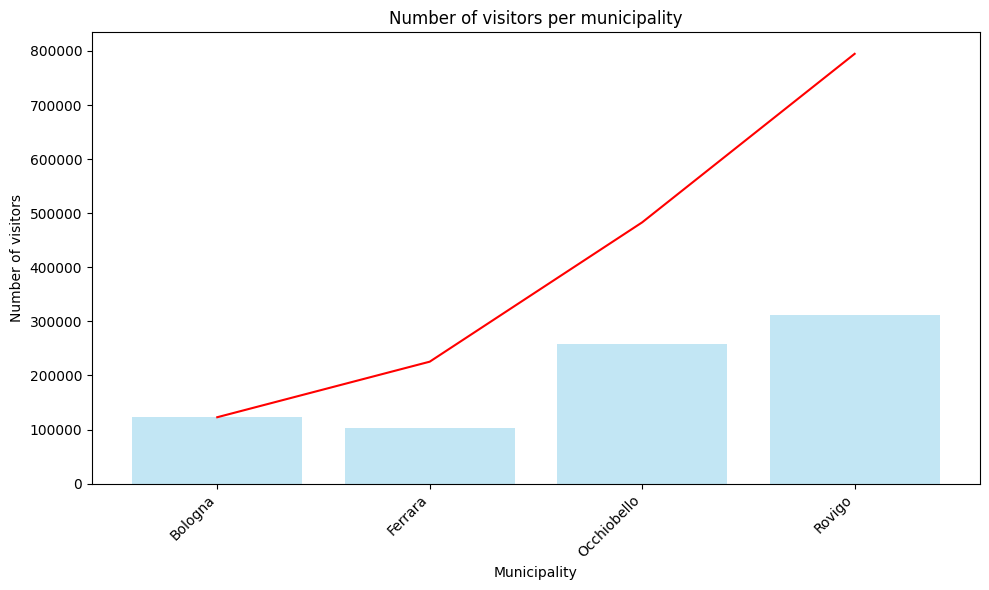

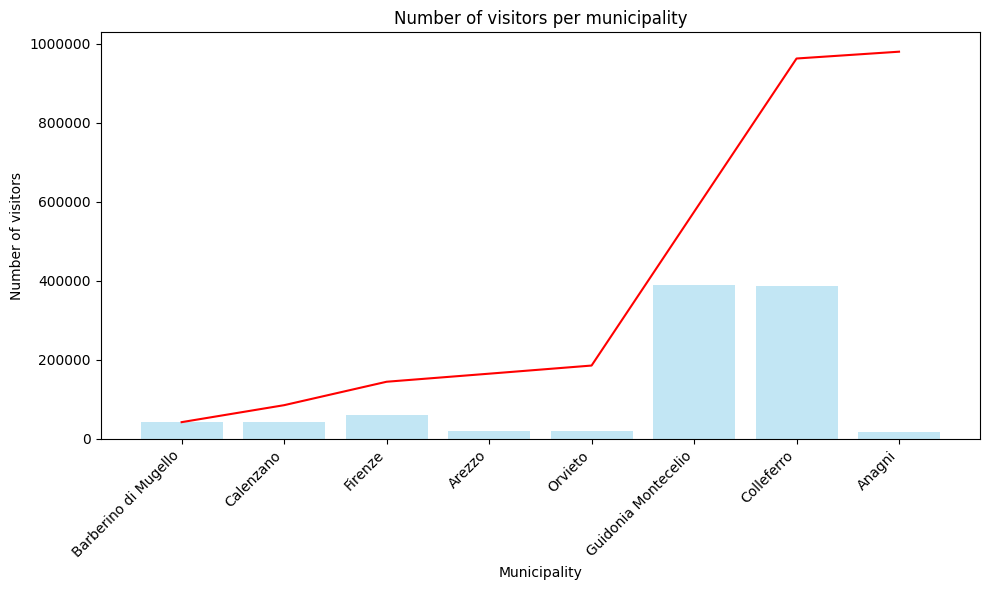

In [188]:
visitors_fluxes(filename_distinct_user_day)

### 2.1. Mid-range mobility through highways
Mobility to/from nearby regions, which are Lombardia, Trentino Alto Adige, Friuli Venezia Giulia, Emilia Romagna.

In [ ]:
visitors_fluxes(filename_distinct_user_day, mid_range=True) #Through Highways

In [ ]:
visitors_fluxes(filename_distinct_user_day, mid_range=True, highway=False) #Through Urban roads

### 2.2 Week flow

Consider the provinces located on the three directions that are mostly contributing to the flow of weekend visitors and working daily commuters by performing a more detailed study of the fluxes based on the day of the week. Use the data available to provide what you believe is the best possible answer.

In [ ]:
visitors_fluxes(filename_distinct_user_day, dow_study=True)

In [ ]:
def plotter(data1, data2, label):
    #Saving the informations per highway
    A13_Roma_Bologna = data1.FLOW.loc['Roma'] + data1.FLOW.loc['Bologna']
    A4_Milano_Torino = data1.FLOW.loc['Milano'] + data1.FLOW.loc['Torino']
    A4_Venezia_Trieste = data1.FLOW.loc['Venezia'] + data1.FLOW.loc['Trieste']

    highway1 = [A13_Roma_Bologna, A4_Milano_Torino, A4_Venezia_Trieste]

    #Saving the informations per highway
    A13_Roma_Bologna = data2.FLOW.loc['Roma'] + data2.FLOW.loc['Bologna']
    A4_Milano_Torino = data2.FLOW.loc['Milano'] + data2.FLOW.loc['Torino']
    A4_Venezia_Trieste = data2.FLOW.loc['Venezia'] + data2.FLOW.loc['Trieste']

    highway2 = [A13_Roma_Bologna, A4_Milano_Torino, A4_Venezia_Trieste]

    #Labels for the plot
    highway_labels = ["A13 Roma-Bologna", "A4 Milano-Torino", "A4 Venezia-Trieste"]
    
    # Plotting
    plt.figure(figsize=(10, 4))
    '''
    plt.bar(highway_labels, highway, color='skyblue')
    plt.xlabel(label)
    plt.ylabel('Visitors'' flow')
    plt.title('Visitors'' flow in ' + label)
    # Set the scale to avoid the exponential notation 
    plt.ticklabel_format(style='plain', axis='y')
    plt.tight_layout()
    '''
    # Plot dei valori
    plt.plot(highway_labels, highway1, marker='o')  # 'marker' specifica il tipo di marker per i punti
    plt.plot(highway_labels, highway2, marker='x')  # 'marker' specifica il tipo di marker per i punti
    plt.xlabel('X')  # Etichetta asse x
    plt.ylabel('Y')  # Etichetta asse y
    plt.title('Plot tipo funzione dei valori di un DataFrame')  # Titolo del grafico
    plt.grid(False)  # Abilita la griglia

    plt.show()
    #Fare istogramma grouped bar

In [ ]:
'''
Seleziono i turisti per le tre direzioni, poi li suddivido in weekend e working days
'''
def dow_visitors_fluxes(data):
    data_weekend = data.loc[(data['DOW'] == "Domenica") | (data['DOW'] == "Sabato")]

    data_working_day = data.loc[~data.index.isin(data_weekend.index)]

    # #Join between customers_data and province_codes in this way filters the province_codes in which we're not interested
    # data_weekend = pd.merge(weekend_flow, data, on='COD_PRO')
    # data_working_day = pd.merge(working_day_flow, data, on='COD_PRO')

    #Counting the flows ov visitors from every city we're interested (both ways)
    data_weekend = data_weekend.groupby(['PROVINCIA'])[['FLOW']].sum()
    data_working_day = data_working_day.groupby(['PROVINCIA'])[['FLOW']].sum()

    plotter(data_weekend, data_working_day, "Weekend")
    # plotter(data_working_day, "Working ")

In [ ]:
dow_visitors_fluxes(visitors_fluxes(filename_day_od))

# 3
Plot the distribution of the number of visitors by the distance of the province of origin. Determine which kind of function should be used to describe the distribution.

è scritto visitor quindi tolgo i non visitor

In [ ]:
def data_visitors_distance(province_data):
    distances_data = pd.read_csv(province_data, sep="\t", encoding="UTF-8", usecols=['DEST_PROCOM', 'KM_TOT'])

    distances_data.rename(columns={'DEST_PROCOM': 'PRO_COM'}, inplace=True)

    distances_data['KM_TOT'] = distances_data['KM_TOT'].str.replace(',','.')
    distances_data['KM_TOT'] = pd.to_numeric(distances_data['KM_TOT'])

    distances_data = distances_data.groupby(['PRO_COM'])[['KM_TOT']].mean()

    customers_data = pd.read_csv(filename_distinct_user_day, encoding="latin1", usecols=['PRO_COM','VISITORS','CUST_CLASS'])

    # Escludo Padova
    customers_data['PRO_COM'] = np.where(customers_data['PRO_COM'] == 28060.0 , np.nan,
                                np.where(customers_data['CUST_CLASS'] != 'visitor', np.nan, customers_data['PRO_COM']))
    customers_data.dropna(axis=0, inplace=True)

    # Elimina la colonna "CUST_CLASS"
    customers_data = customers_data.drop('CUST_CLASS', axis=1)

    customers_data = customers_data.groupby(['PRO_COM'])[['VISITORS']].sum()

    data = pd.merge(distances_data, customers_data, on='PRO_COM')

    data = data.sort_values(['VISITORS'], ascending=False)

    return data

In [ ]:
data_visitors_distance(filename_distance_to_pd_txt)

In [ ]:
def plot_visitors_distance(data, zoom=1):
    # zoom serve a raggruppare le distanze (50 --> raggruppo le distanze ogni 50 km)
    # calcolo il range di raggruppamento
    period = int(data['KM_TOT'].max() / zoom)
    somma_visitatori = []
    for n_group in range(1,period+1):
        data_grouped = data[data['KM_TOT'].between((n_group-1)*zoom +1 , n_group * zoom)]
        somma_visitatori.append(data_grouped['VISITORS'].sum())
    
    data_to_plot = pd.DataFrame({'DISTANCE_TO_PD': [km * zoom for km in range(0, period)], 'VISITORS': somma_visitatori})
    # Impostare l'indice dopo la creazione del DataFrame
    data_to_plot.set_index('DISTANCE_TO_PD', inplace=True)

    # data_to_plot['KM_TOT'] = np.where(data_to_plot['KM_TOT'] == 0 , np.nan, data_to_plot['KM_TOT'])
    # data_to_plot.dropna(axis=0, inplace=True)

    # data_nearby = data.loc[(data['KM_TOT'] < 50)]

    # data_far = data.loc[~data.index.isin(data_nearby.index)]

    plt.figure(figsize=(10, 6))
    plt.hist(data_to_plot['VISITORS'], color='blue', alpha=0.7, bins=20)
    plt.xlabel('Distance from Padova (KM)')
    plt.ylabel('Number of Visitors')
    plt.title('Histogram of Distance from Padova')
    plt.grid(True, linestyle='--', linewidth=0.5)
    plt.show()
    #Da riguardare il grafico

In [ ]:
plot_visitors_distance(data_visitors_distance(filename_distance_to_pd_txt), 50)

### 3.1 
Assuming an analytic form can be used to describe the trend, create a regression or a fit to estimate the expected number of visitors by the distance of the province of origin and the corresponding uncertainties. Illustrate the difference between the resulting regression with respect to the numbers provided by the Vodafone monitoring, and highlight the five most striking discrepancies from the expectations.

In [ ]:
from sklearn.linear_model import LinearRegression

# Build linear regression model using TV and Radio as predictors
# Split data into predictors X and output Y
X = np.array(data['KM_TOT']).reshape(-1,1)
y = data['VISITORS']

# Initialise and fit model
lm = LinearRegression()
model = lm.fit(X, y)
# plot for residual error
 
   
plt.scatter(X,y,color='red')
plt.plot(X,model.predict(X),color='green')
plt.title('Simple Linear Regression')
plt.xlabel('Position Level')
plt.ylabel('Salary')
plt.show()